# Simulation Run Log Analysis and Visualization for AWS DeepRacer

This notebook walks through how you can analyze and debug using the AWS DeepRacer Simulation logs 


1. Tools to find best iteration of your model
1. Visualize reward distribution on the track
 - Visualize reward heatmap per episode or iteration
1. Identify hotspots on the track for your model
1. Understand probability distributions on simulated images
1. Evaluation run analysis - plot lap speed heatmap


## Requirements

boto3 >= 1.9.133  ; configure your aws cli and/or boto credentials file

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

## IAM permissions


Assign your Sagemaker notebook an execution role with permission to access the deepracer service. Typically this is done by providing "deepracer:*" permissions.

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import boto3
import shutil
import os
import glob
import math
import tarfile
import json
%matplotlib inline

In [2]:
#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

In [3]:
from log_analysis import *
from os import listdir
from os.path import isfile, join


## Jobs run from AWS DeepRacer Console. Download the desired log file by providing model name

In [4]:
model_name="SteerSpeedDist-Diff-8Hours" ## Change to your model
is_training = True  ## Make this False if you want to do log analysis on Evaluation.
year_month = "2022-October"
deepracer_path = "/Users/rohan/Documents/python-projects/deepracer"

In [5]:
!rm -rf ./tmp
!rm -rf ./intermediate_checkpoint

In [6]:
simtrace_path = "{}/{}/Logs-{}/training-simtrace/".format(deepracer_path, year_month, model_name)
if not is_training:
    simtrace_path = "{}/{}/Logs-{}/evaluation-*/evaluation-simtrace/".format(deepracer_path, year_month, model_name)
merged_simtrace_path = "./logs/deepracer-{}-{}.csv".format(year_month, model_name)

In [7]:
!mkdir -p intermediate_checkpoint/{year_month}-{model_name}/model-artifacts
!mkdir -p ./tmp
!rsync -a --delete --include="*.csv" --exclude="*" {simtrace_path} ./tmp/

In [8]:
!cp {deepracer_path}/{year_month}/Logs-{model_name}/model.tar.gz-extracted/model_metadata.json intermediate_checkpoint/{year_month}-{model_name}/model-artifacts
!cp {deepracer_path}/{year_month}/Logs-{model_name}/model.tar.gz-extracted/worker_0.multi_agent_graph_0.json intermediate_checkpoint/{year_month}-{model_name}/model-artifacts
!cp {deepracer_path}/{year_month}/Logs-{model_name}/model.tar.gz-extracted/worker_0.multi_agent_graph.main_level.main_level.agent_0.csv intermediate_checkpoint/{year_month}-{model_name}/model-artifacts

In [9]:
with open("intermediate_checkpoint/{}-{}/model-artifacts/model_metadata.json".format(year_month, model_name),"r") as jsonin:
    model_metadata=json.load(jsonin)
sensor = [sensor for sensor in model_metadata['sensor'] if sensor != "LIDAR"][0]
model_metadata

{'action_space': {'steering_angle': {'high': 30.0, 'low': -30.0},
  'speed': {'high': 1.0, 'low': 0.5}},
 'sensor': ['FRONT_FACING_CAMERA'],
 'neural_network': 'DEEP_CONVOLUTIONAL_NETWORK_SHALLOW',
 'version': '4',
 'training_algorithm': 'clipped_ppo',
 'action_space_type': 'continuous'}

## Job run from Public Notebook. Download the desired log file given the simulation ID 

#### Merge all the csv files into one big .csv file

In [10]:
def get_sort_csv_file():
    sim_trace_csvs = glob.glob("./tmp/*.csv")
    csvs_with_ids = [(int(os.path.basename(file).split("-")[0]), file) for file in sim_trace_csvs]
    csvs_sorted = sorted(csvs_with_ids, key=lambda csvs_with_ids: csvs_with_ids[0])
    return [csv_file[1] for csv_file in csvs_sorted]
    
def merge_csv_files(output_file_path):
    csv_files = get_sort_csv_file()
    header_saved = False
    with open(output_file_path, 'w') as fout:
        for csv_file in csv_files:
            with open(csv_file) as fin:
                header = next(fin)
                if not header_saved:
                    fout.write(header)
                    header_saved = True
                for line in fin:
                    line = re.sub(r'(\[[^\]]*\])', r'"\1"', line, flags=re.M)
                    fout.write(line)

merge_csv_files(merged_simtrace_path)
!tail -n 3 $merged_simtrace_path

479,864.0,7.347778286953273,0.29626381570390564,89.02060075560306,-12.857660664000882,0.9893009910713186,"[-12.857660664000882, 0.9893009910713186]",1.5370291659094943,False,True,99.93973727027698,143,45.297381734332326,15057.365,in_progress,0.0
479,865.0,7.350086373564123,0.3080249616992736,88.46811886218555,-15.466241875467876,0.8329062706498285,"[-15.466241875467876, 0.8329062706498285]",0.4815235909919108,False,True,99.9658940845082,143,45.297381734332326,15057.413,in_progress,0.0
479,866.0,7.370688595902253,0.41130007542669755,84.75838194796377,6.933413042399373,0.5,"[6.933413042399373, 0.5]",0.8253864970908282,True,True,100,144,45.297381734332326,15057.474,lap_complete,0.0


## Load waypoints for the track you want to run analysis on


In [11]:
track_path = "{}/deepracer-k1999-race-lines/tracks/".format(deepracer_path)
ListFiles = [f for f in listdir(track_path) if isfile(join(track_path, f))]
print(ListFiles)

['reInvent2019_track.npy', '2022_august_open.npy', 'Canada_Training.npy', 'canada_race.npy', 'Tokyo_Training_track.npy', 'Oval_track.npy', 'New_York_Track.npy', 'Bowtie_track.npy', 'H_track.npy', 'reinvent_base.npy', '2022_september_open.npy', 'Mexico_track.npy', 'Virtual_May19_Train_track.npy', 'Straight_track.npy', 'AWS_track.npy', 'China_track.npy', '2022_july_open.npy', '2022_june_open.npy', 'London_Loop_Train.npy']


In [12]:
def get_track_waypoints(track_name):
    return np.load("%s/%s.npy" % (track_path, track_name))

trackname="2022_september_open"
waypoints = get_track_waypoints(trackname)
waypoints.shape

(152, 6)

## Visualize the Track and Waypoints

In [13]:
def plot_points(ax, points):
    ax.scatter(points[:-1,0], points[:-1,1], s=1)
    for i,p in enumerate(points):
        ax.annotate(i, (p[0], p[1]))

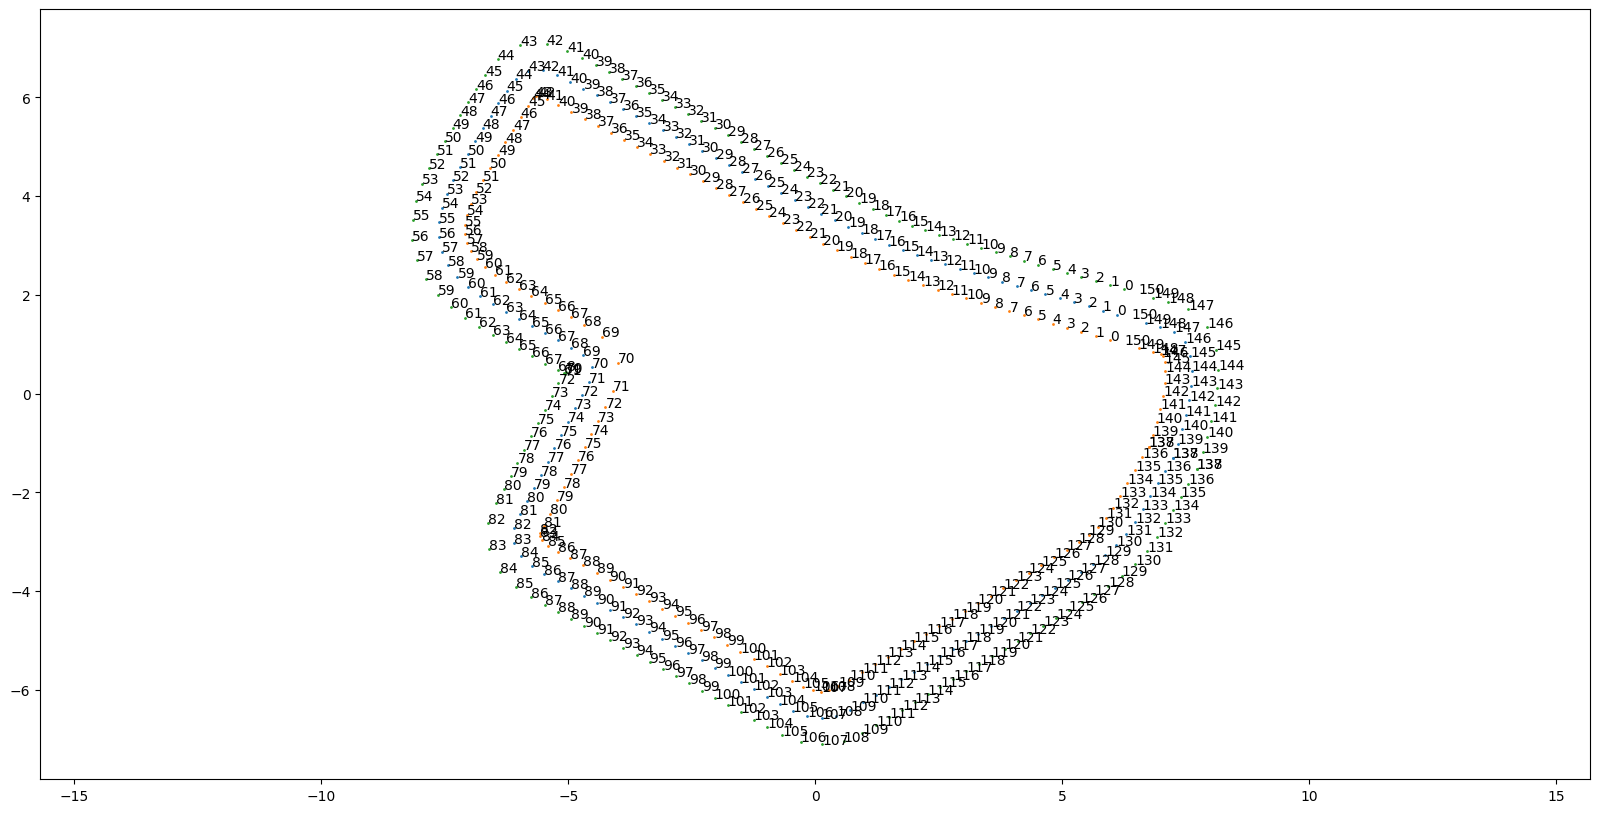

In [14]:
# Plot the results
fig, ax = plt.subplots(figsize=(20,10))
plot_points(ax, waypoints[:-1,0:2])
plot_points(ax, waypoints[:-1,2:4])
plot_points(ax, waypoints[:-1,4:6])
ax.axis('equal')
plt.show()

<__array_function__ internals>:180: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


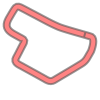

In [15]:
l_center_line = LineString(waypoints[:,0:2])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))

road_poly

In [16]:
# rescale waypoints to centimeter scale

center_line = waypoints[:,0:2] 
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

# Helper Functions 

In [17]:
def plot_track(df, track_size=(500, 800), x_offset=0, y_offset=0, scale=100):
    '''
    Each track may have a diff track size, 
    For reinvent track, use track_size=(500, 800)
    Tokyo, track_size=(700, 1000)
    x_offset, y_offset is used to convert to the 0,0 coordinate system
    '''
    #track = np.zeros(track_size) # lets magnify the track by *100
    #for index, row in df.iterrows():
    #    x = int(row["x"]*scale + x_offset)
    #    y = int(row["y"]*scale + y_offset)
    #    reward = row["reward"]
    #    track[y, x] = reward
    #   plt.plot(y,x,reward)
    allx=[]
    ally=[]
    allreward=[]
    for index, row in df.iterrows():
        x = float(row["x"])
        y = float(row["y"])
        reward = float(row["reward"])
        allx.append(x)
        ally.append(y)
        allrewards=reward
        #track[y, x] = reward
        #plt.plot(y,x,reward)
    heatmap, xedges, yedges = np.histogram2d(allx, ally, bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        
    #fig = plt.figure(1, figsize=(12, 16))
    fig = plt.figure(1, figsize=track_size)
    ax = fig.add_subplot(111)
    print_border(ax, center_line, inner_border, outer_border)
    return heatmap.T,extent

In [18]:
def plot_top_laps(sorted_idx, n_laps=5):
    fig = plt.figure(n_laps, figsize=(12, 30))
    for i in range(n_laps):
        idx = sorted_idx[i]
        
        episode_data = episode_map[idx]
        
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border)
        plot_coords(ax, line)
        plot_line(ax, line)


        for idx in range(1, len(episode_data)-1):
            x1,y1,action,reward,angle,speed = episode_data[idx]
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1, car_x2], [y1, car_y2], 'b.')
        
    return fig

## Load the training log

In [19]:
EPISODE_PER_ITER = 20 if is_training else 1

In [20]:
df = pd.read_csv(merged_simtrace_path)
iteration_arr = np.arange(math.ceil(df.episode.max()/EPISODE_PER_ITER)+1) * EPISODE_PER_ITER
df['iteration'] = np.digitize(df.episode, iteration_arr)
df = df.rename(columns={"X": "x", "Y": "y", "tstamp": "timestamp"})
df.head()

,episode,steps,x,y,yaw,steer,throttle,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,timestamp,episode_status,pause_duration,iteration
0,0,1.0,5.982886,1.640088,164.126304,1.084680,0.658389,"[1.0846798273014073, 0.6583890852045173]",0.000000,False,True,0.309405,0,45.297382,33.958,prepare,0.0,1
1,0,2.0,5.982810,1.640114,164.125689,-30.000000,0.725934,"[-30.0, 0.7259338792206403]",0.000000,False,True,0.309581,0,45.297382,34.002,in_progress,0.0,1
2,0,3.0,5.958771,1.649860,163.381729,17.440695,0.900887,"[17.440695255053846, 0.9008870039158797]",1.170173,False,True,0.366511,1,45.297382,34.082,in_progress,0.0,1
3,0,4.0,5.913971,1.666923,162.475818,-12.290795,0.657645,"[-12.290794658477207, 0.6576450471229733]",2.011821,False,True,0.471945,1,45.297382,34.177,in_progress,0.0,1
4,0,5.0,5.889224,1.675433,162.273280,6.036035,0.717727,"[6.036035119189108, 0.7177270858563658]",1.201140,False,True,0.529635,1,45.297382,34.217,in_progress,0.0,1


If the model loaded uses a continuous action space, convert it to a discrete action space for analysis. This will map the choices the model made in the simtrace logs into discrete buckets to allow for later visualization.

In [21]:
NUM_ANGLE_BUCKETS = 5
NUM_SPEED_BUCKETS = 4

if 'action_space_type' in model_metadata and model_metadata['action_space_type']=='continuous':
    max_angle = model_metadata['action_space']['steering_angle']['high']
    min_angle = model_metadata['action_space']['steering_angle']['low']

    max_speed = model_metadata['action_space']['speed']['high']
    min_speed = model_metadata['action_space']['speed']['low']

    #Determine which discrete bucket would be the equivalent for the continuous action space
    for index, row in df.iterrows():        
        angle_bucket = math.floor(((row["steer"] - min_angle)/(max_angle-min_angle))*NUM_ANGLE_BUCKETS)
        speed_bucket = math.floor(((row["throttle"] - min_speed)/(max_speed-min_speed))*NUM_SPEED_BUCKETS)
        if angle_bucket==NUM_ANGLE_BUCKETS:
            angle_bucket -= 1
        if speed_bucket==NUM_SPEED_BUCKETS:
            speed_bucket -= 1
        df.at[index,"action"] = int(angle_bucket*NUM_SPEED_BUCKETS+speed_bucket)
    

    #Convert the model metadata in memory to use the new forced discrete action space
    angle_bucket_size = (max_angle-min_angle)/NUM_ANGLE_BUCKETS
    angle = min_angle+.5*angle_bucket_size
    speed_bucket_size = (max_speed-min_speed)/NUM_SPEED_BUCKETS
    speed = min_speed+.5*speed_bucket_size    
    model_metadata['action_space'] = []
    index = 0
    for anglei in range(0,NUM_ANGLE_BUCKETS):
        for speedi in range(0,NUM_SPEED_BUCKETS):
            model_metadata['action_space'].append({'index':index,
                                 'speed': speed,
                                 'steering_angle': angle})
            index+=1
            speed += speed_bucket_size
        angle += angle_bucket_size
        speed = min_speed+.5*speed_bucket_size
            
    print(df.head())

   episode  steps         x         y         yaw      steer  throttle action  \
0        0    1.0  5.982886  1.640088  164.126304   1.084680  0.658389      9   
1        0    2.0  5.982810  1.640114  164.125689 -30.000000  0.725934      1   
2        0    3.0  5.958771  1.649860  163.381729  17.440695  0.900887     15   
3        0    4.0  5.913971  1.666923  162.475818 -12.290795  0.657645      5   
4        0    5.0  5.889224  1.675433  162.273280   6.036035  0.717727     13   

     reward   done  all_wheels_on_track  progress  closest_waypoint  \
0  0.000000  False                 True  0.309405                 0   
1  0.000000  False                 True  0.309581                 0   
2  1.170173  False                 True  0.366511                 1   
3  2.011821  False                 True  0.471945                 1   
4  1.201140  False                 True  0.529635                 1   

   track_len  timestamp episode_status  pause_duration  iteration  
0  45.297382     3

In [22]:
df['y'].min(), df['x'].max()

(-7.330065097484224, 8.39393450243789)

In [23]:
# Normalize the rewards to a 0-1 scale

from sklearn.preprocessing import  MinMaxScaler
min_max_scaler = MinMaxScaler()
scaled_vals = min_max_scaler.fit_transform(df['reward'].values.reshape(df['reward'].values.shape[0], 1))
df['reward'] = pd.DataFrame(scaled_vals.squeeze())


In [24]:
df['reward'].min(), df['reward'].max()

(0.0, 0.9999999999999999)

## Plot rewards per Iteration

This graph is useful to understand the mean reward and standard deviation within each episode 

Number of episodes =  479


Text(0.5, 0, 'Episode')

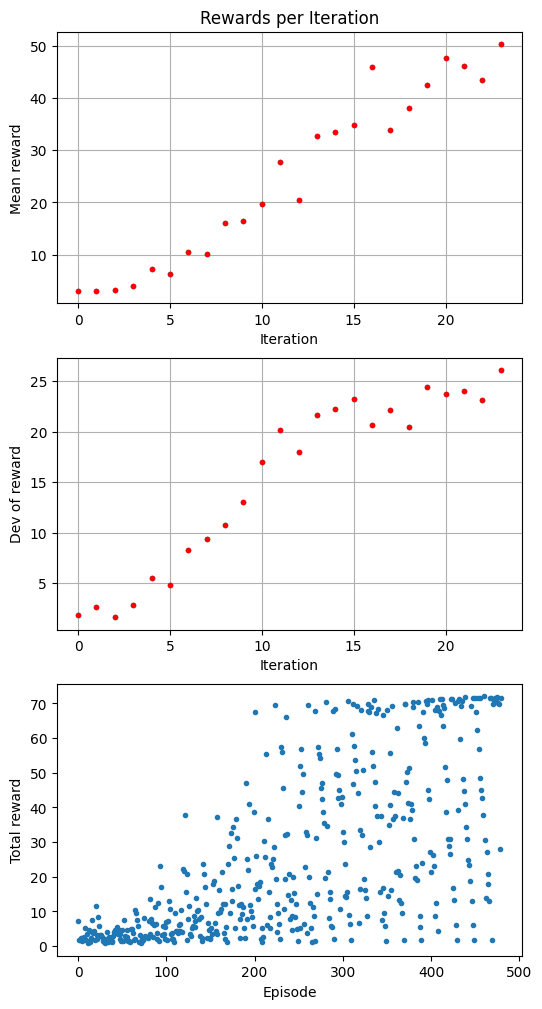

In [25]:
REWARD_THRESHOLD = 0

# reward graph per episode
min_episodes = np.min(df['episode'])
max_episodes = np.max(df['episode'])
print('Number of episodes = ', max_episodes)

total_reward_per_episode = list()
    
for epi in np.arange(min_episodes, max_episodes+1,1):
    df_slice = df[df['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()

buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)

    if len(buffer_rew) == EPISODE_PER_ITER:
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        # reset
        buffer_rew = list()


fig = plt.figure(figsize=(6, 12))
ax = fig.add_subplot(311)
ax.plot(np.arange(len(average_reward_per_iteration)), average_reward_per_iteration, '.')
ax.set_title('Rewards per Iteration')
ax.set_ylabel('Mean reward')
ax.set_xlabel('Iteration')

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD :
        ax.plot(rr, average_reward_per_iteration[rr], 'r.')

plt.grid(True)

ax = fig.add_subplot(312)
ax.plot(np.arange(len(deviation_reward_per_iteration)), deviation_reward_per_iteration, '.')

ax.set_ylabel('Dev of reward')
ax.set_xlabel('Iteration')
plt.grid(True)

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD:
        ax.plot(rr, deviation_reward_per_iteration[rr], 'r.')


ax = fig.add_subplot(313)
ax.plot(np.arange(len(total_reward_per_episode)), total_reward_per_episode, '.')
ax.set_ylabel('Total reward')
ax.set_xlabel('Episode')

## Analyze training/evaluation metrics with progress and reward function

This graph gives you an idea whether your model has convergered or more training is required. If you see the curve trending upwards then more training time would help the agent to get better rewards

In [26]:
if is_training:
    METRIC_PATH = "{}/{}/Logs-{}/metrics/TrainingMetrics.json".format(deepracer_path, year_month, model_name)
else:
    METRIC_PATH = glob.glob("{}/{}/Logs-{}/metrics/EvaluationMetrics-*.json".format(deepracer_path, year_month, model_name))[0]

with open(METRIC_PATH, "r") as fp:
    data = json.loads(fp.read())
    metric_data = data['metrics']
    df_metrics = pd.DataFrame(metric_data)

if is_training:
    df_metrics = df_metrics[df_metrics['phase'] == "training"]

In [27]:
df_metrics

,reward_score,metric_time,start_time,elapsed_time_in_milliseconds,episode,trial,phase,completion_percentage,episode_status
0,178,41952,33920,8032,1,1,training,12,Off track
1,39,44145,42073,2072,2,2,training,2,Off track
2,39,46344,44216,2128,3,3,training,3,Off track
3,57,49037,46403,2634,4,4,training,4,Off track
4,29,51103,49123,1980,5,5,training,2,Off track
...,...,...,...,...,...,...,...,...,...
617,1930,15057474,14999480,57994,480,20,training,100,Lap complete
624,1382,15453040,15409343,43697,481,1,training,74,Off track
625,1917,15510860,15453099,57761,482,2,training,100,Lap complete
626,1858,15568774,15510945,57829,483,3,training,100,Lap complete


Mean percentage: 36.756198347107436


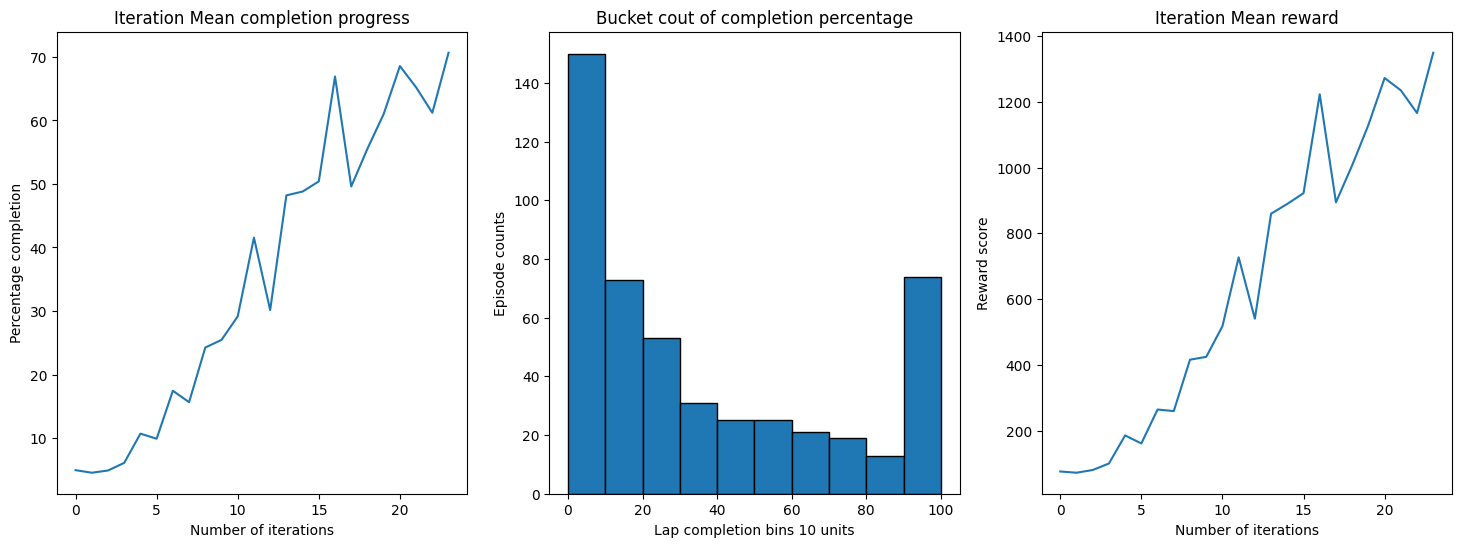

In [28]:
bins= [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

df_metrics = df_metrics.sort_values(by="metric_time")
print('Mean percentage: {}'.format(df_metrics.completion_percentage.mean()))

completion_percentage_np = np.array(df_metrics.completion_percentage)
episode_progress_buckets = np.split(completion_percentage_np[:EPISODE_PER_ITER*(len(completion_percentage_np)//EPISODE_PER_ITER)],
                                    len(completion_percentage_np)//EPISODE_PER_ITER)
episode_progress_mean = np.mean(episode_progress_buckets, axis=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
# Line graph showing the mean iteration of completion progress
ax1.plot(episode_progress_mean)
ax1.title.set_text('Iteration Mean completion progress')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Percentage completion')

# Bar chart to show completion_percentage with bucketing of 10% bar chart
ax2.hist(df_metrics.completion_percentage, bins=bins, edgecolor="k")
ax2.title.set_text('Bucket cout of completion percentage')
ax2.set_xlabel('Lap completion bins 10 units')
ax2.set_ylabel('Episode counts')

# Line graph showing the mean iteration of reward mean
if is_training:
    reward_score_np = np.array(df_metrics.reward_score)
    episode_reward_buckets = np.split(reward_score_np[:EPISODE_PER_ITER*(len(reward_score_np)//EPISODE_PER_ITER)],
                                                      len(reward_score_np)//EPISODE_PER_ITER)
    episode_reward_mean = np.mean(episode_reward_buckets, axis=1)
    ax3.plot(episode_reward_mean)
    plt.title("Metric analysis - Reward/percentage vs number of iterations")
    ax3.title.set_text('Iteration Mean reward')
    ax3.set_xlabel('Number of iterations')
    ax3.set_ylabel('Reward score')
    plt.show()


## Analyze the reward distribution for your reward function

In [29]:
print("Min x-axis {}; Max x-axis {}".format(np.min(df['x']), np.max(df['x'])))
print("Min y-axis {}; Max y-axis {}".format(np.min(df['y']), np.max(df['y'])))

Min x-axis -8.373417990843997; Max x-axis 8.39393450243789
Min y-axis -7.330065097484224; Max y-axis 7.30668938740863


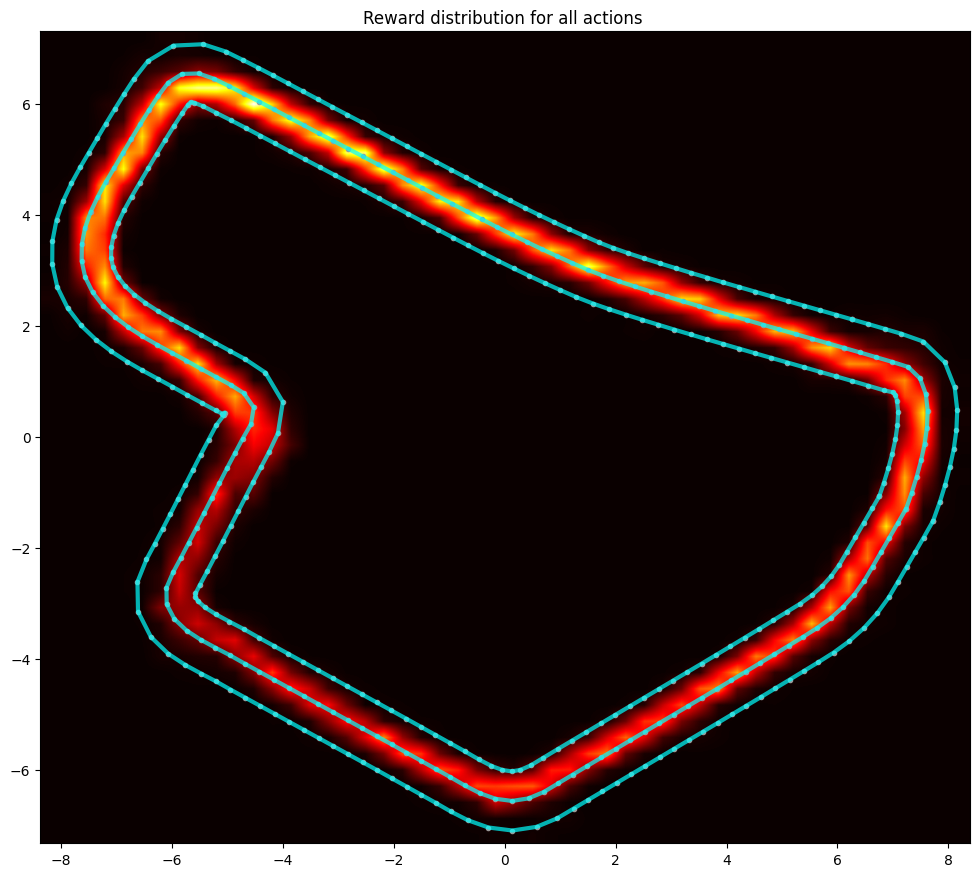

In [30]:
track,extent = plot_track(df, track_size=(12, 12), x_offset=0, y_offset=0)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', extent=extent, interpolation='bilinear', origin="lower") 

### Plot a particular iteration


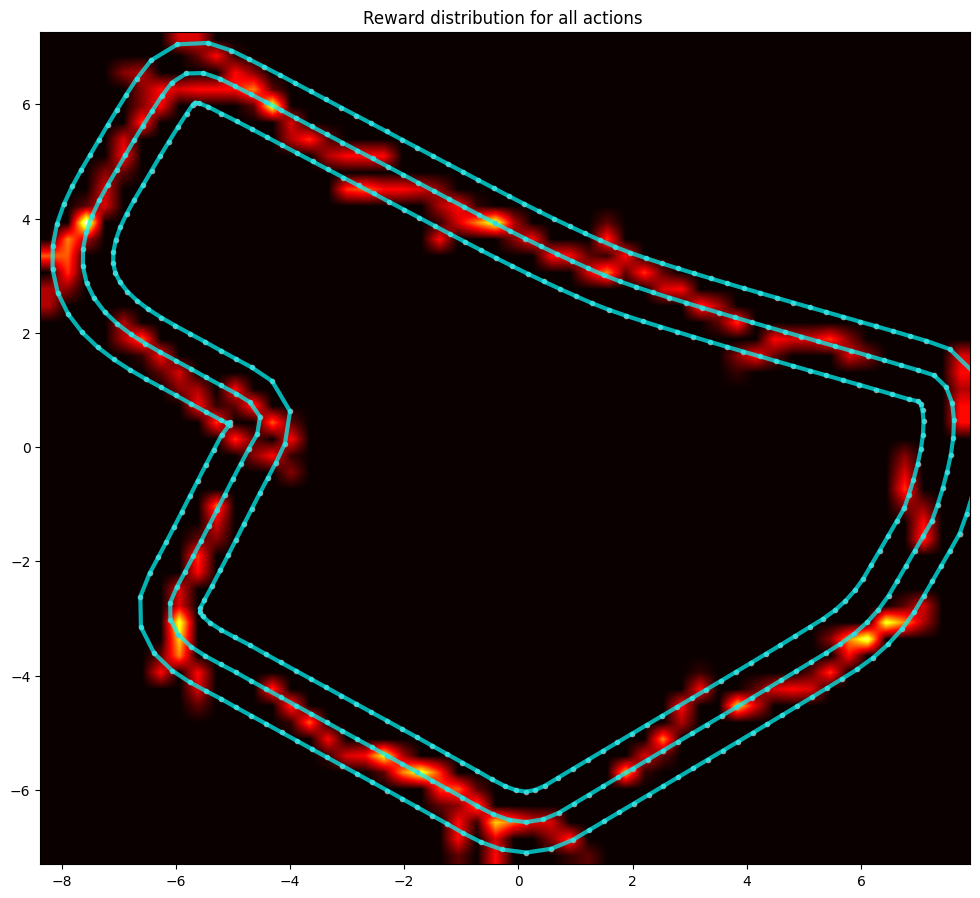

In [31]:
iteration_id = 3
track,extent = plot_track(df[df['iteration'] == iteration_id], track_size=(12, 12), x_offset=0, y_offset=0)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', extent=extent, interpolation='bilinear', origin="lower") 

### Path taken for top reward iterations

NOTE: in a single episode, the car can go around multiple laps, the episode is terminated when car completes 1000 steps

The top 3 highest reward episodes are [460, 475, 439]


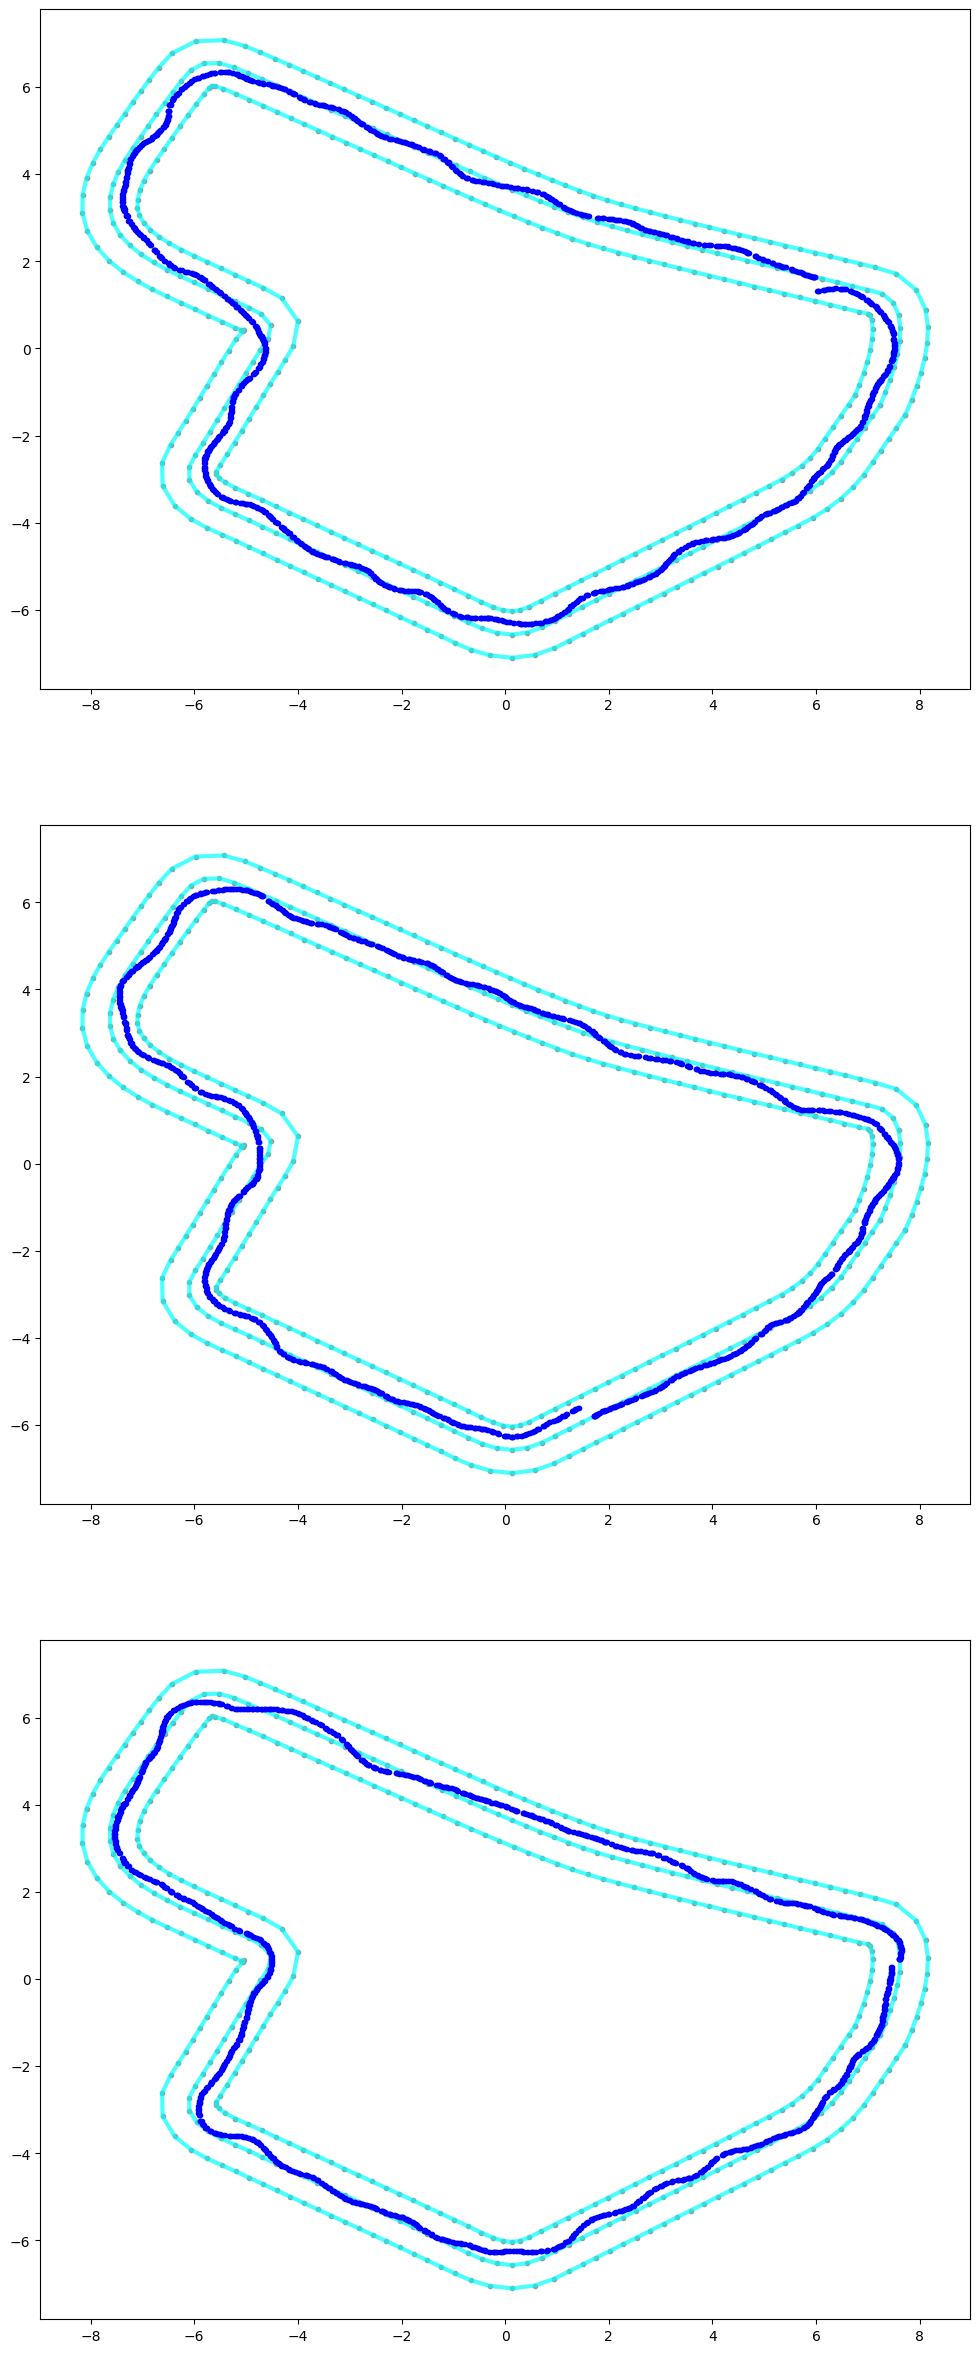

In [32]:
action_map, episode_map, sorted_idx = episode_parser(df)    
fig = plot_top_laps(sorted_idx[:], 3)
print("The top 3 highest reward episodes are {}".format(sorted_idx[:3]))

### Path taken in a particular episode

In [33]:
## Evaluation RUN
def plot_episode_run(df, E):
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(211)
    print_border(ax, center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')

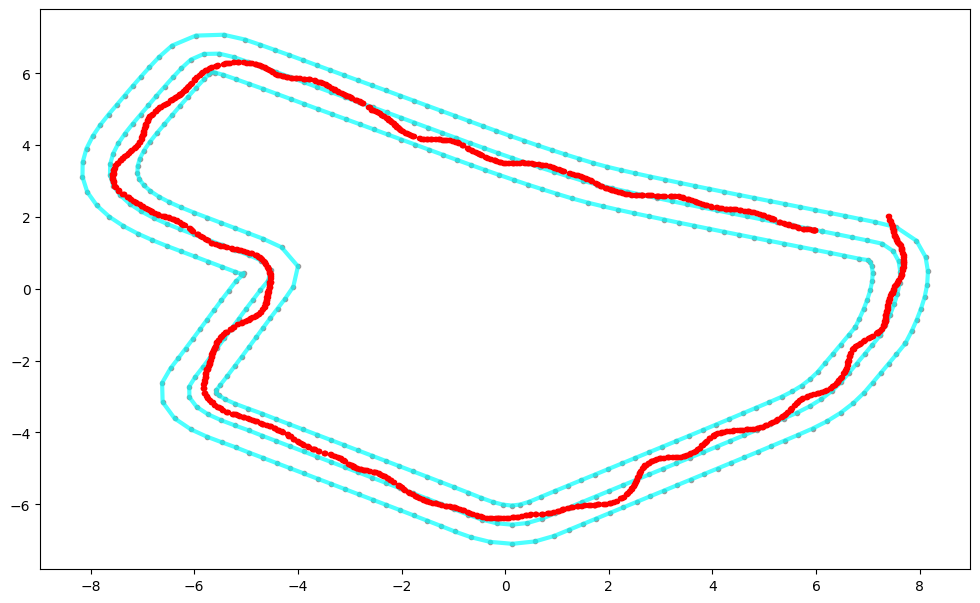

In [34]:
plot_episode_run(df, E=200) # arbitrary episode

### Path taken in a particular Iteration

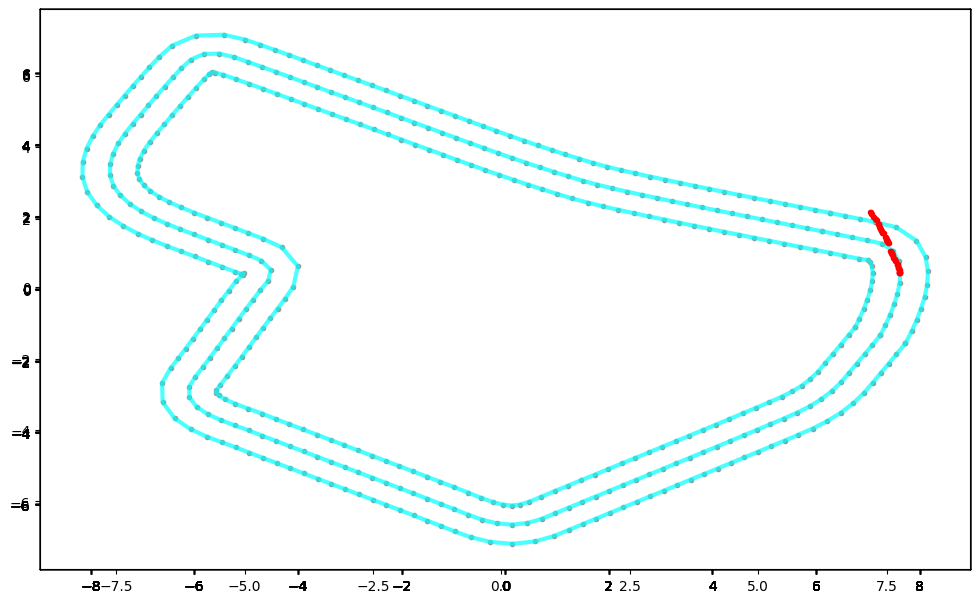

In [35]:
iteration_id = 1

for i in range((iteration_id-1)*EPISODE_PER_ITER, (iteration_id)*EPISODE_PER_ITER):
    plot_episode_run(df, E=i)

## Action breakdown per iteration and historgram for action distribution for each of the turns - reinvent track

This plot is useful to understand the actions that the model takes for any given iteration.

Say you want the car to go at higher speeds on the straight line. This will give you an idea what actions the car is taking along those segments

In [37]:
# The actions plotted on the tracks may become noise. Use this to clip the low reward values action.
# Anything with reward < 0.8 is clipped. This is based on the reward function you trained on.

REWARD_THRESHOLD = 0.8

In [38]:
# Track Segment Labels
action_names = []
for action in model_metadata['action_space']:
    action_names.append("ST"+str(action['steering_angle'])+" SP"+"%.2f"%action["speed"])
action_names

['ST-24.0 SP0.56',
 'ST-24.0 SP0.69',
 'ST-24.0 SP0.81',
 'ST-24.0 SP0.94',
 'ST-12.0 SP0.56',
 'ST-12.0 SP0.69',
 'ST-12.0 SP0.81',
 'ST-12.0 SP0.94',
 'ST0.0 SP0.56',
 'ST0.0 SP0.69',
 'ST0.0 SP0.81',
 'ST0.0 SP0.94',
 'ST12.0 SP0.56',
 'ST12.0 SP0.69',
 'ST12.0 SP0.81',
 'ST12.0 SP0.94',
 'ST24.0 SP0.56',
 'ST24.0 SP0.69',
 'ST24.0 SP0.81',
 'ST24.0 SP0.94']

**Define track labels**

This hash defines the labels for track segments on various tracks. Analyzing new tracks will require adding a new entry to this hash.

In [40]:
track_segments_hash = { "reinvent_base": [(0, 'straightaway'),
                                          (20, 'hairpin'),
                                          (46, 'slight right'),
                                          (61, 'left'),
                                          (76, 'slight left'),
                                          (90, 'straightaway'),
                                          (103, 'left'),
                                          (113, 'straightaway')                                         
                                          ],
                       "reInvent2019_track": [(0, 'left'),
                                              (18, 'sharp right'),
                                              (33, 'gentle left'),
                                              (82, 'left'),
                                              (93, 'slight left'),
                                              (107, 'left'),
                                              (117, 'right'),
                                              (137, 'left')
                                             ],
                       "arctic_open": [(0, 'straightaway'),
                                       (24,'left'),
                                       (36,'right'),
                                       (52,'left'),
                                       (67,'hairpin left'),
                                       (84,'right'),
                                       (98,'slight left'),
                                       (107,'straightaway'),
                                       (125,'slight left'),
                                       (134,'straightaway'),
                                       (156,'hairpin left')            
                       ],
                       "caecer_loop": [(0, 'straightaway'),
                                       (14,'slight left'),
                                       (34,'straightaway'),
                                       (42,'hairpin left'),
                                       (70,'straightaway'),
                                       (80,'sharp left'),
                                       (93,'straightaway'),
                                       (103,'slight left'),
                                       (115,'straightaway')            
                       ],
                       "red_star_open":[(0,'straightaway'),
                                        (29,'left'),
                                        (41,'straightaway'),
                                        (67,'hairpin left'),
                                        (78,'straightaway'),
                                        (94,'s-turn right'),
                                        (107,'s-turn left'),
                                        (119,'s-turn right'),
                                        (130,'s-turn left'),
                                        (140,'straightaway'),
                                        (155,'sharp left'),
                                        (163,'straightaway')                           
                       ],
                       "2022_july_open":[(0, 'straightaway'),
                                         (22, 'left turn'),
                                         (28, 'straightaway'),
                                         (44, 'left turn'),
                                         (51, 'straightaway'),
                                         (61, 's-turn left'),
                                         (72, 's-turn right'),
                                         (85, 'straightaway'),
                                         (91, 'right turn'),
                                         (97, 'straightaway'),
                                         (102, 'u-turn left'),
                                         (116, 'straightaway'),
                                         (127, 'left turn')
                       ]
}
trackname

'2022_july_open'

Number of steps in iteration= 6174


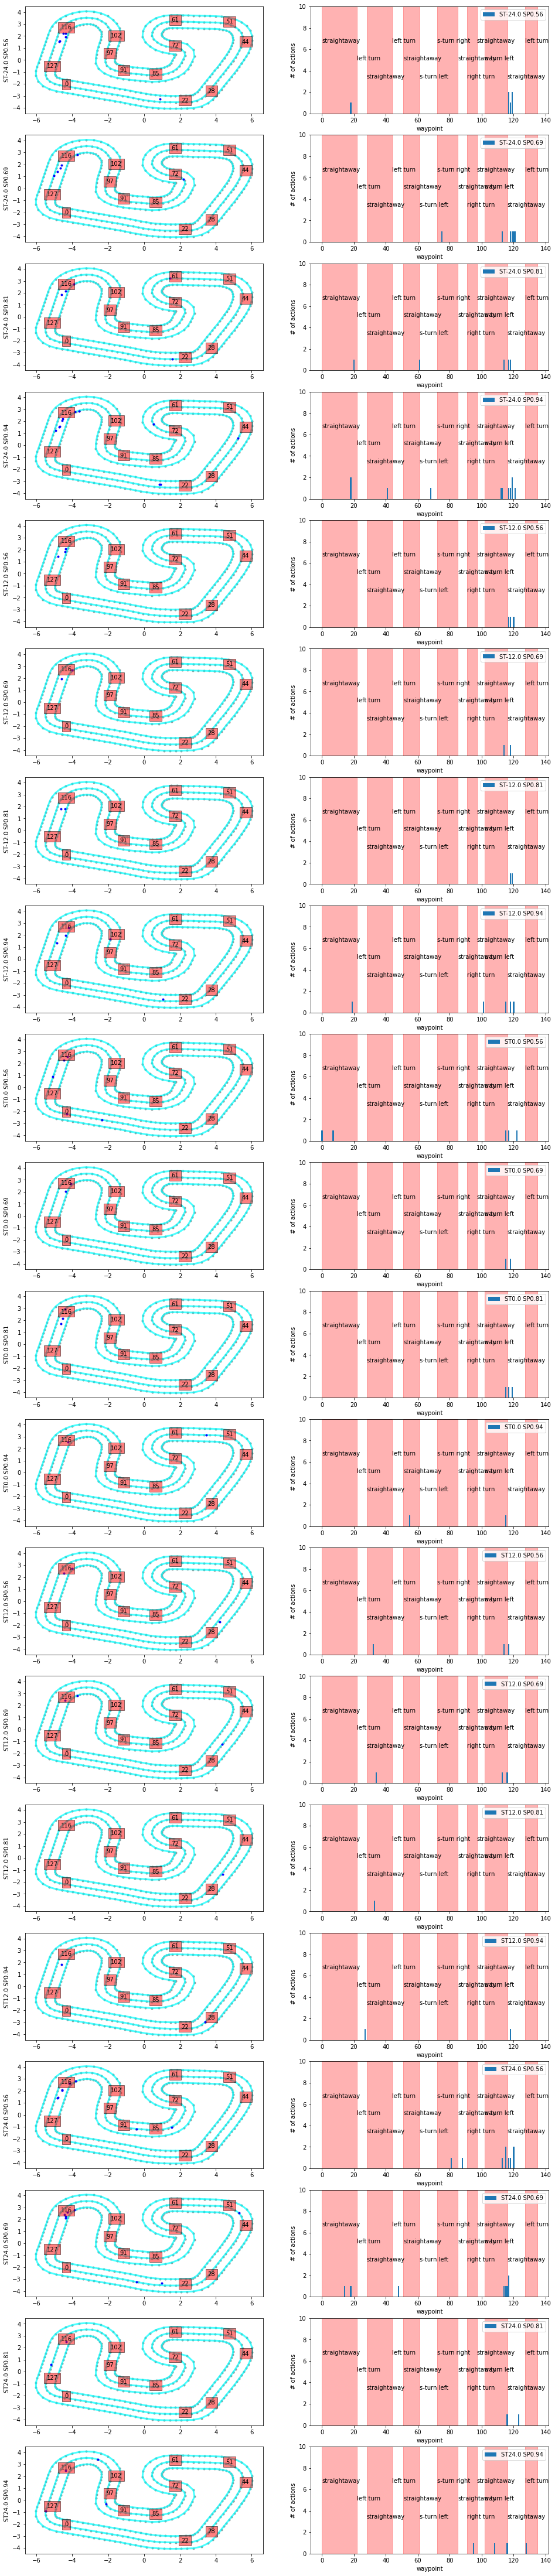

In [41]:
fig = plt.figure(figsize=(16, 4*len(action_names)))
iterations_downselect = [iteration_id] ## Lets pick the iteratons with the highest rewards

y_limit = 10
track_segments = track_segments_hash[trackname]
segment_x=[]
segment_y=[]
segment_xerr_l=[]
segment_xerr_r=[]
segment_yerr_n=[]
segment_yerr_s=[]
i=0
while i<len(track_segments):
    segment_x.append(track_segments[i][0])
    segment_y.append(0)
    segment_xerr_l.append(0)
    if i>=len(track_segments)-1:
        segment_xerr_r.append(len(waypoints)-track_segments[i][0])
    else:
        segment_xerr_r.append(track_segments[i+1][0]-track_segments[i][0])
    segment_yerr_n.append(0)
    segment_yerr_s.append(y_limit)
    i+=2

segment_x = np.array(segment_x)
segment_y = np.array(segment_y)
segment_xerr = np.array([segment_xerr_l,segment_xerr_r])
segment_yerr = np.array([segment_yerr_n,segment_yerr_s])

#segment_x = np.array(vert_lines)
#segment_y = np.array([0]*len(vert_lines))
#segment_xerr = np.array([[0]*len(vert_lines),[1]*len(vert_lines)])
#segment_yerr = np.array([[0]*len(vert_lines), [150]*len(vert_lines)])

wpts_array = center_line 
text_y=[.66*y_limit,.5*y_limit,.33*y_limit]
    
for iter_num in iterations_downselect:

    # Slice the data frame to get all episodes in that iteration
    df_iter = df[(iter_num == df['iteration'])]
    n_steps_in_iter = len(df_iter)
    print('Number of steps in iteration=', n_steps_in_iter)

    # Reward function threshold
    th = REWARD_THRESHOLD
    for idx in range(len(action_names)):
        ax = fig.add_subplot(len(action_names), 2, 2*idx+1)
        print_border(ax, center_line, inner_border, outer_border) 
            
        df_slice = df_iter[df_iter['reward'] >= th]
        df_slice = df_slice[df_slice['action'] == idx]

        ax.plot(df_slice['x'], df_slice['y'], 'b.')

        for idWp in track_segments:
            ax.text(wpts_array[idWp[0]][0], wpts_array[idWp[0]][1], str(idWp[0]), bbox=dict(facecolor='red', alpha=0.5))

        #ax.set_title(str(log_name_id) + '-' + str(iter_num) + ' w rew >= '+str(th))
        ax.set_ylabel(action_names[idx])

        # calculate action way point distribution
        action_waypoint_distribution = list()
        for idWp in range(len(wpts_array)):
            action_waypoint_distribution.append(len(df_slice[df_slice['closest_waypoint'] == idWp]))

        ax = fig.add_subplot(len(action_names), 2, 2 * idx + 2)

        # Call function to create error boxes
        _ = make_error_boxes(ax, segment_x, segment_y, segment_xerr, segment_yerr)


        i=0
        for tt in range(len(track_segments)):
            ax.text(track_segments[tt][0], text_y[i], track_segments[tt][1])
            i = (i+1)%len(text_y)

        ax.bar(np.arange(len(wpts_array)), action_waypoint_distribution)
        ax.set_xlabel('waypoint')
        ax.set_ylabel('# of actions')
        ax.legend([action_names[idx]])
        ax.set_ylim((0, y_limit))